# Welcome!
In this notebook we will try to answer the following questions: 

- Study the influence of mean rating of businesses on mobility. Do good ratings and bad ratings of businesses influence human mobility? If yes, how?

- Study of the word of mouth impact on friends’ recommendations. How do friends’ recommendations influence our mobility?  How likely are we to visit a friend's recommended business?

- Study of the word of mouth impact on weekdays. Depending on the day of the week, are we more likely to travel far? Does the influence of friend’s recommendations change depending on the day of the week ?

- Study of the word of mouth impact on categories of businesses. Are there categories of businesses more influenced by friends reviews than others? 

- Study the 'treatment' having a good rating vs not, with methods seen in the course. Does a good rating have an influence on the number of visits of the business? Is there a correlation between ratings and the number of visits?


# Table of Contents
* [I. Import libraries](#I.-Import-libraries)
* [II. Data Wangling](#II.-Data-Wangling)
    * [Prepare the dataframe for business](#Prepare-the-dataframe-for-business)
    * [Prepare the dataframe for users](#Prepare-the-dataframe-for-users)
    * [Prepare the dataframe for reviews](#Prepare-the-dataframe-for-reviews)
    * [Prepare categories of businesses](#Prepare-categories-of-businesses)
    * [Add category labels to business dataframe](#Add-category-labels-to-business-dataframe)
    * [Prepare review dataframe with only selected users](#Prepare-review-dataframe-with-only-selected-users)

* [III. Data Analysis](#III.-Data-Analysis)
    * [Load the data & some insights](#II.-Load-the-data-&-some-insights)
    * [Influence of the mean rating of businesses on mobility](#III.-Influence-of-the-mean-rating-of-businesses-on-mobility)
        * [Find User's home](#Find-User's-home)
        * [Study of the probability of move to a business far away from home and give a good review](#Study-of-the-probability-of-move-to-a-business-far-away-from-home-and-give-a-good-review)
    * [Words of mouth impact](#IV.-Words-of-mouth-impact)    
        * [Get the reviewed label](#Get-the-reviewed-label)
        * [Study friends' ratings influence on mobility](#Study-friends'-ratings-influence-on-mobility)
    * [Week day study](#Week-day-study)
        * [Influence of friend's reviews depending on week day](#Influence-of-friend's-reviews-depending-on-week-day)
    * [Category study](#Category-study)
    * [Well rated business and poorely rated buisnesses](#Well-rated-business-and-poorely-rated-buisnesses)
    
        * [Distribution of the number of visits of well rated places vs badly rated places](#Distribution-of-the-number-of-visits-of-well-rated-places-vs-badly-rated-places)
    * [Distribution of checkins accross category](#Distribution-of-checkins-accross-category)
    * [Study distribution of number of checkins per business depending on rating and per catagory](#Study-distribution-of-number-of-checkins-per-business-depending-on-rating-and-per-catagory)
* [IV. Data Story](#IV.-Data-Story)
    * [Codes for intervative plots for data story](#Codes-for-intervative-plots-for-data-story)

# I. Import libraries

In [1]:
import json
import math
import pickle
import numpy as np
import pandas as pd
import chart_studio
import seaborn as sns
import plotly.io as pio
from bisect import bisect
import plotly.express as px
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.figure_factory as ff
from math import radians, cos, sin, asin, sqrt

# II. Data Wangling
### Prepare the dataframe for business

The original business file is a `csv` file of 148 MB. However, only some attributes are useful. So useless columns are removed from the data. The new dataframe is stored as a csv named df_user.csv. This file has 46.8 MB.

In [2]:
# Read original dataframe
df_business_ori = pd.read_json("./data/yelp_academic_dataset_business.json", lines = True)

In [3]:
# Keep only relevant colunms
df_business = df_business_ori[['business_id','state','latitude','longitude', 'categories','stars']].copy()
# Show an example
df_business[:3]

,business_id,state,latitude,longitude,categories,stars
0,f9NumwFMBDn751xgFiRbNA,NC,35.462724,-80.852612,"Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...",3.5
1,Yzvjg0SayhoZgCljUJRF9Q,AZ,33.569404,-111.890264,"Health & Medical, Fitness & Instruction, Yoga,...",5.0
2,XNoUzKckATkOD1hP6vghZg,QC,45.479984,-73.580070,"Pets, Pet Services, Pet Groomers",5.0


In [4]:
# Save smaller dataframe as csv in order to not load the entire dataset next time
df_business.to_csv('./data/df_business.csv',index=False)

### Prepare the dataframe for users
The original user file is a `json` file of 3.3 GB. However, we only use attributes `user_id` and `firends`. So a new dataframe for users is created and stored as a `csv` named `df_user.csv`. This file has 2.5 GB.

In [5]:
# Read large json file of user
with open("./data/yelp_academic_dataset_user.json") as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data)) 

In [6]:
# Convert to DataFrame
df_user_ori = pd.DataFrame(data)    
# Keep only relevant colunms
df_users = df_user_ori[['user_id','friends']].copy()

In [7]:
# Show an example
df_users[:3]

,user_id,friends
0,ntlvfPzc8eglqvk92iDIAw,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg..."
1,FOBRPlBHa3WPHFB5qYDlVg,"ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug..."
2,zZUnPeh2hEp0WydbAZEOOg,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ..."


In [8]:
# Save smaller dataframe as csv in order to not load the entire dataset next time
df_users.to_csv('./data/df_user.csv',index=False)

### Prepare the dataframe for reviews

The original review file is a `json` file of 6.3 GB containing many useless attributes. We have used `jq`, a tool which allows us to select the desired attribute. The result is stored in a `csv` file named `df_reviews.csv`. This file has 729.9 MB.

In [9]:
# Read the review file
df_review = pd.read_csv("./data/df_reviews.csv")
# Show an example
df_review.head()

,review_id,user_id,business_id,stars,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1,2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4,2017-01-14 21:56:57


### Prepare categories of businesses

The categories used to describe the businesses were way too specific, so we decided to label those 1336 very sharp categories to 17 more general categories described in the `business_category-list.pdf`, making it easier to make some analysis around those 17 labels. Since this labelling was done by hand, we had to correct a few of the typos (missing letters, lower cases, additional spaces). The 17 more general categories are `Automotive`, `BusinessSupport`, `Computer(& Elecetronics)`, `Construction`, `Education`, `Entertainment`, `Food(& Dining)`, `Health`, `Home(& Garden)`, `Legal(& Finance)`, `Manufacturing`, `Merchant`, `Miscellaneous`, `PersonalCare`, `RealEstate`, `Sport`, `Travel(& Transportation)`.

In [10]:
# Read prepared csv mapping category name to category label
df_categories = pd.read_csv('./data/name_category.csv')

In [11]:
def correction_name(x):
    """
        Sanitize category name
        x: row of the dataframe
        Return: sanitized category name
    """
    name = x[0]
    name = name.replace("'", "")
    return name

def correction_category(x):
    """
        Sanitize category label
        x: row of the dataframe
        Return: sanitized category
    """
    category = x[1]
    category = category.replace(" ", "")
    category = category.replace("Consruction", "Construction")
    category = category.replace("Constructor", "Construction")
    category = category.replace("Entertainement", "Entertainment")
    category = category.replace("Entertainemnt", "Entertainment")
    category = category.replace("Entertainments", "Entertainment")
    category = category.replace("Merchants", "Merchant")
    category = category.replace("'", "")
    category = category.replace("Mischellaneous", "Miscellaneous")
    category = category.replace("food", "Food")
    return category

In [12]:
# Sanitize category name and category label
df_categories['name'] = df_categories.apply(lambda x: correction_name(x), axis=1)
df_categories['category'] = df_categories.apply(lambda x: correction_category(x), axis=1)

In [13]:
# Save sanitized file
df_categories.to_csv('./data/name_category.csv', index=False)

### Add category labels to business dataframe

In [14]:
# Add category labels to business dataframe
df_business['categories'] = df_business.categories.apply(lambda x: [] if x == None else x.split(', '))

In [15]:
# Create a dictionary mapping category name to category label
dict_categories = df_categories.set_index('name')['category'].to_dict()
# Tokenize the category label and store in a dictionary
indexCategory = {val: key for key, val in enumerate(set(df_categories['category']))}

In [16]:
def create_category_mask(row): 
    """
        For categories of each business, create a mask of categories
        row: row of the dataframe
        Return: mask of categories. If 1 at index i, it means that the business have i-th category.
    """
    res  = np.zeros(numberCat)
    for r in row:
        category = dict_categories.get(r)
        index = indexCategory.get(category)
        res[index] = 1
    return res > 0
# Vectorize the function 
#create_category_mask_vect = np.vectorize(test, signature='()->(k)')

In [17]:
# Fetch the number of categories
numberCat = len(set(df_categories['category']))
# Create category mask for each business in reviews
categoryMask = df_business.apply(lambda row: create_category_mask(row.categories),axis=1)

In [18]:
# For each category, add a new column to the business dataframe
for category_name in set(df_categories['category']):
    # Create "category_name" column, and assign the category mask
    # If mask at row i is True, it means that the business at row i has category: "category_name"
    df_business[category_name] = [tup[indexCategory.get(category_name)] for tup in categoryMask]

In [19]:
# Show an example
df_business.head(2)

,business_id,state,latitude,longitude,categories,stars,Construction,Computers,Home,Merchant,...,Education,Legal,BusinessSupport,PersonalCare,Entertainment,RealEstate,Automotive,Food,Miscellaneous,Health
0,f9NumwFMBDn751xgFiRbNA,NC,35.462724,-80.852612,"[Active Life, Gun/Rifle Ranges, Guns & Ammo, S...",3.5,False,False,False,True,...,False,False,False,True,True,False,False,False,False,False
1,Yzvjg0SayhoZgCljUJRF9Q,AZ,33.569404,-111.890264,"[Health & Medical, Fitness & Instruction, Yoga...",5.0,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [20]:
# Save smaller dataframe as csv in order to not load the entire dataset next time
df_business.to_csv('./data/df_business.csv',index=False)

### Prepare review dataframe with only selected users
For our study, we need to infer user's home, so we need **at least 3 reviews**. Also, we will study users with **at least 3 friends**. 

In [21]:
# Convert the string of friends to a list
df_users['friend_list'] = df_users.apply(lambda x: x.friends.split(', '), axis=1)
df_users = df_users.drop('friends', axis=1)

In [23]:
# We count the number of reviewe per user
df_numberOfReviews = df_review.groupby('user_id').count().drop(['business_id', 'stars', 'date'], axis = 1).rename(columns={'review_id': 'review_count'})

In [24]:
# We merge the df_users dataset to the df_numberOfReviews dataset
df_users = pd.merge(df_users, df_numberOfReviews, left_on='user_id', right_on='user_id', how='inner')

In [25]:
# We create a mask for users with more than 3 friends
mask = df_users.apply(lambda x: len(x.friend_list) >= 3, axis=1)

In [26]:
print('Number of users with more than 3 reviews:', df_numberOfReviews[df_numberOfReviews['review_count'] >= 3].shape[0])
print('Number of users with more than 3 friends:', df_users[mask].shape[0])

Number of users with more than 3 reviews: 602736
Number of users with more than 3 friends: 957463


In [27]:
# Select users that satisfy both conditions
df_selectedUsers = df_users[mask&(df_users['review_count'] >= 3)]
print('Number of users with more than 3 reviews and with more than 3 friends:', df_selectedUsers.shape[0])

Number of users with more than 4 reviews and with more than 3 friends: 343424


In [37]:
# Save smaller user dataframe as csv in order to not load the entire dataset next time
df_selectedUsers.to_csv('./data/selectedUsers.csv',index=False)

In [28]:
# Number of checkins of the selected users
print('Number of checkins of selected users:', df_selectedUsers['review_count'].sum())

Number of checkins of selected users: 4516345


Prepare a dataframe containly only selected users.

In [29]:
# Merge review and business dataframe
df_review = pd.merge(df_review, df_business, left_on='business_id', right_on='business_id', how='inner').drop(['state'], axis=1)

In [33]:
# Select only rows of selected users
df_selectedReviews = df_review[df_review["user_id"].isin(df_selectedUsers.user_id)]

In [34]:
# Convert date to datetime object
df_selectedReviews["date"] = pd.to_datetime(df_selectedReviews.date.values)

<ipython-input-34-f0a7b85b7e69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selectedReviews["date"] = pd.to_datetime(df_selectedReviews.date.values)


In [40]:
# Show an example
df_selectedReviews.head()

,review_id,user_id,business_id,stars_x,date,latitude,longitude,categories,stars_y,Construction,...,Education,Legal,BusinessSupport,PersonalCare,Entertainment,RealEstate,Automotive,Food,Miscellaneous,Health
1,t7xOZF5UKXjSpVcXLOSAgw,owbC7FP8SNAlwv6f9S5Stw,-MhfebM0QIsKt87iDN-FNw,2,2014-03-14 08:24:25,36.112896,-115.177637,"[Shopping, Arts & Entertainment, Art Galleries...",3.5,False,...,False,False,False,False,True,False,False,False,False,False
2,MimB5Xh85rG7phUMPrShag,v9vGnjphb0Hta0lvtf5haA,-MhfebM0QIsKt87iDN-FNw,3,2015-10-07 22:16:59,36.112896,-115.177637,"[Shopping, Arts & Entertainment, Art Galleries...",3.5,False,...,False,False,False,False,True,False,False,False,False,False
4,cnV5xtm6WuyaLfot9uWbDg,LkWNo83Lg92C5V4JEyxOZA,-MhfebM0QIsKt87iDN-FNw,3,2010-10-10 01:27:31,36.112896,-115.177637,"[Shopping, Arts & Entertainment, Art Galleries...",3.5,False,...,False,False,False,False,True,False,False,False,False,False
5,i593z2rGxk5Lj23Bx9o1Lg,mLtaUzSjIFO_3BmfPNUKqg,-MhfebM0QIsKt87iDN-FNw,1,2015-08-20 01:10:53,36.112896,-115.177637,"[Shopping, Arts & Entertainment, Art Galleries...",3.5,False,...,False,False,False,False,True,False,False,False,False,False
6,TWpbq_vbpJRotCQ6l8SeXA,wKX1tAeRIYPU4NtM-R5N2w,-MhfebM0QIsKt87iDN-FNw,5,2012-03-31 22:00:15,36.112896,-115.177637,"[Shopping, Arts & Entertainment, Art Galleries...",3.5,False,...,False,False,False,False,True,False,False,False,False,False


In [36]:
# Save smaller dataframe as csv in order to not load the entire dataset next time
df_selectedReviews.to_csv('./data/selectedReviews.csv',index=False)

# III. Data Analysis
## Load the data & some insights
In this section we get some first basic information about the data.

In [11]:
# We load the 4 pre-processed datasets 
df_business = pd.read_csv('./data/df_business.csv')
df_reviews = pd.read_csv('./data/df_reviews.csv')
df_users = pd.read_csv('./data/df_user.csv')
df_selectedReviews = pd.read_csv('./data/selectedReviews.csv')
df_selectedUsers = pd.read_csv('./data/selectedUsers.csv')

For reading purposes, the 4 datasets have the following form.

In [12]:
# Show an example
df_business.head(3)

,business_id,state,latitude,longitude,stars,categories
0,f9NumwFMBDn751xgFiRbNA,NC,35.462724,-80.852612,3.5,"Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh..."
1,Yzvjg0SayhoZgCljUJRF9Q,AZ,33.569404,-111.890264,5.0,"Health & Medical, Fitness & Instruction, Yoga,..."
2,XNoUzKckATkOD1hP6vghZg,QC,45.479984,-73.580070,5.0,"Pets, Pet Services, Pet Groomers"


In [13]:
# Show an example
df_reviews["date"] = pd.to_datetime(df_reviews.date.values)
df_reviews.head(3)

,review_id,user_id,business_id,stars,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,2015-12-05 03:18:11


In [14]:
# Convert the string of friends to a list
df_users['friend_list'] = df_users.apply(lambda x: x.friends.split(', '), axis=1)
df_user = df_users.drop('friends', axis=1)
# Show an example
df_users.head(3)

,user_id,friends,friend_list
0,ntlvfPzc8eglqvk92iDIAw,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...","[oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfD..."
1,FOBRPlBHa3WPHFB5qYDlVg,"ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...","[ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOu..."
2,zZUnPeh2hEp0WydbAZEOOg,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...","[Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnP..."


In [15]:
print('There are', df_business.shape[0], 'businesses.')
print('There are', df_reviews.shape[0], 'reviews.')
print('There are', df_users.shape[0], 'users.')

There are 209393 businesses.
There are 8021122 reviews.
There are 1968703 users.


In [5]:
# Convert date to datetime object
df_selectedReviews["date"] = pd.to_datetime(df_selectedReviews.date.values)
# Show an example
df_selectedReviews.head(3)

,review_id,user_id,business_id,stars_x,date,latitude,longitude,stars_y,reviewed_by_friend_before,square_id,dist_checkin_home,week_day
0,t7xOZF5UKXjSpVcXLOSAgw,owbC7FP8SNAlwv6f9S5Stw,-MhfebM0QIsKt87iDN-FNw,2,2014-03-14 08:24:25,36.112896,-115.177637,3.5,-1,160_-413,3.490097,4
1,MimB5Xh85rG7phUMPrShag,v9vGnjphb0Hta0lvtf5haA,-MhfebM0QIsKt87iDN-FNw,3,2015-10-07 22:16:59,36.112896,-115.177637,3.5,-1,160_-413,1.435575,2
2,cnV5xtm6WuyaLfot9uWbDg,LkWNo83Lg92C5V4JEyxOZA,-MhfebM0QIsKt87iDN-FNw,3,2010-10-10 01:27:31,36.112896,-115.177637,3.5,2,160_-413,3.632600,6


In [151]:
# Convert the string of friends to a list
df_selectedUsers['friend_list'] = df_selectedUsers.apply(lambda x: x.friend_list.split(', '), axis=1)
# Show an example
df_selectedUsers.head(3)

,user_id,friend_list,review_count,latitude_home,longitude_home
0,ntlvfPzc8eglqvk92iDIAw,"['oeMvJh94PiGQnx_6GlndPQ', 'wm1z1PaJKvHgSDRKfw...",58,36.131612,-115.163849
1,FOBRPlBHa3WPHFB5qYDlVg,"['ly7EnE8leJmyqyePVYFlug', 'pRlR63iDytsnnniPb3...",64,33.639702,-112.383382
2,zZUnPeh2hEp0WydbAZEOOg,"['Uwlk0txjQBPw_JhHsQnyeg', 'Ybxr1tSCkv3lYA0I1q...",3,36.114935,-115.191060


In [152]:
print('There are', df_selectedUsers.shape[0], 'users that have at least 3 reviews and 3 friends.')
print('There are', df_selectedReviews.shape[0], 'reviews corresponding to those users.')

There are 343424 users that have at least 3 reviews and 3 friends.
There are 4516345 reviews corresponding to those users.


**Why do we select users?**    
In later part of this study, we will be computing each users' home. That is why we consider users having made at least 3 reviews. The idea behind that is that with 2 reviews we can infer the user's home and with the 3rd one you can see how far the user went for a checkin far away from home. 
If we kept users who made only 2 reviews, the number of 'inactive users' would be far too great, and most checkins would be made at zero km from home.    
Also, we are only considering users with at least 3 friends, because we will try to understand if a friend's review increases our chance to visit the place in the future. To make that study, we need users with active friends (i.e users with at least 3 friends). 


**What is a good review and a bad review?**    
In this study we will be distingising good and bad reviews. However, what is a good review and what is a bad review.    
To understand that, we next plot the distribution of ratings on the 209393 available businesses.    
*NB: we will be displaying this figure in our datastory so we import some librares to export the figure to our datastory website*.


In [177]:
# Plot the distribution of ratings on businesses 
fig = px.histogram(df_business['stars'], x="stars", hover_data=["stars"], nbins=100, marginal="box")
fig.show()

<img src="./images/histogram_mean_rating.png">

***NB: this is an image of the real figure (plotty plots are not saved into the hard memory of the notebook) so we display an image of the actual figure. For interaction, please visit our website.***

In [ ]:
# Export the figure to an HTML file that will be displated on the datastory
pio.write_html(fig, file="rating_distribution.html", auto_open=True)

As we can see on the figure above, the 25k lowest rated businesses have 2 or less stars and the +25k best reviewed businesses have 5 stars. Hence, from now on we will consider the following:
* a good review is a review of 5 stars
* a bad review is a review of 2 or less stars

## Influence of the mean rating of businesses on mobility
Lets now dive into the subject.    
First, we will study movement of users depending on the mean rating of each business.     
We consider that a user has "checked-in" to a location if he made a review on that place.
What we would like to understand is if users are willing to travel further from their home to go to a good rated business and see if when they travelled further from home they leave a better review. 
### Find User's home
We first need to find user's homes, for this we assign to each check-in a 25x25km square, and assign as the user's home, the mean of the check-ins made in the square the user has the most check-ins in. (Similar to the original paper).    
Note that we will be computing the user's home of people having made at least 3 checkins (or reviews). 

In [36]:
# Define some constants
ONE_DEGREE_LATITIDE_TO_KM = 111
EARTH_RADIUS = 6371

def getSquareIdString(lat, long):
    '''
        GOAL: unction used to compute the square_id given two coordinate (latitude coordinate and longitude coordinate)
        INPUT: Takes as input two float that represent the latitude and longitude (be aware that order matters!)
        OUTPUT: Returns a string that is the id of the cell in which the two coordinates are located in
        Explanations on this function are given in section I
    '''
    
    lat_id = math.trunc(lat*ONE_DEGREE_LATITIDE_TO_KM/25.0)
    long_id = math.trunc(math.pi/180*EARTH_RADIUS*math.cos(math.radians(lat))*long/25)
    return str(lat_id)+'_'+str(long_id)

# Transform the function used to compute the square_id to a numpy usable function 
# (i.e argumennts of the function can be passed as np.array)
# This is done to improve efficiency by avoiding the use of an apply on a dataframe, which would cause a lot of overhead 
# when working with indices
vect_GetSquareIdString = np.vectorize(getSquareIdString)

In [ ]:
def haversine(x1, x2):
    """
        GOAL: compute the arc-distance between two points with format (latitude, longitude)
             Calculate the great circle distance between two points on the earth (specified in decimal degrees)
        INPUT: Takes two np.array where the first element is the latitude and the second is the longitude (be aware that latitude is first!)
        OUTPUT: return the distance bewteen the two given points
        NOTE: this function was copied verbatim from: 
        https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [x1[1], x1[0], x2[1], x2[0]])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [ ]:
def getUserHome(df):
    '''
        GOAL: compute each user's home
        INPUT: a dataframe of checkins with at lest the 'user_id' of the person who made that checkin, as well 
               as the coordinates of the checkin (latitude and longitude)
        OUTPUT: a dataframe with index the users and as column the coordinare of the user's home
    '''
    # we are using the column time as a counter for the pair (user_id, square_id)
    # in the meantime, we are computing the mean latitude and longitude for each pair (user_id, square_id)
    save = df.groupby(['user_id', 'square_id']).agg({
        'date': 'count', 
        'latitude': ['mean'],
        'longitude': ['mean']
    }).reset_index()
    
    # we copy the counter of pair (user_id, square_id), the mean latitude, and mean longitude 
    # in new columns
    save['count'] = save['date']['count']
    save['latitude_home'] = save['latitude']['mean']
    save['longitude_home'] = save['longitude']['mean']

    # we drop the columns the we previously copied 
    save = save.drop([('date', 'count'), 'square_id', ('latitude', 'mean'), ('longitude', 'mean')], axis=1)
    
    # we keep only the square_id with the most count 
    save = save.loc[save.groupby('user_id')['count'].idxmax()]
    
    # we drop the column count as it will be of no use later
    save = save.drop('count', axis=1)
    return save

In [ ]:
# Compute the square_id for each user
df_selectedReviews['square_id'] = vect_GetSquareIdString(df_selectedReviews['latitude'].values, df_selectedReviews['longitude'].values)

In [25]:
# Compute users' homes for the selected users
df_homes = getUserHome(df_selectedReviews)

In [27]:
# Merge the selected users and the their home coordinates
df_selectedUsers = pd.merge(df_selectedUsers, df_homes, left_on='user_id', right_on='user_id', how='left')

In [ ]:
# Save each user's home for later use
df_homes.to_csv('./df_homes.csv',index=False)

### Study of the probability of move to a business far away from home and give a good review
A first intersting fact to gather could be: are we more satisfied when we travel far from home. In other words, we would like to see if we are more willing to give a good review on a business if we travel far from home. 

In [28]:
# Merge review and business dataframe
df_reviews = pd.merge(df_reviews, df_business, left_on='business_id', right_on='business_id', how='inner').drop(['state'], axis=1)

# Merge review dataframe with selected users
df_complete = pd.merge(df_reviews, df_selectedUsers, left_on='user_id', right_on='user_id', how='right')

# Rename some column name for convenience
# Actual_stars corresponds to the mean rating given to a business (its the aggregation of all user's review on that business)
df_complete = df_complete.rename(columns={('latitude_home', ''): "latitude_home", ('longitude_home', ''): "longitude_home"})
df_business = df_business.rename(columns={"stars":"actual_stars"})

In [31]:
# For each check-in we keep track of the home coordinates, the business coordinates, the categories
# We display a small example of the dataset from that point
df_complete = pd.read_csv('./data/selectedReviews.csv')

In [32]:
df_complete.head(2)

,Unnamed: 0,review_id,user_id,business_id,stars_x,date,latitude,longitude,stars_y,reviewed_by_friend_before,square_id,dist_checkin_home,week_day
0,1,t7xOZF5UKXjSpVcXLOSAgw,owbC7FP8SNAlwv6f9S5Stw,-MhfebM0QIsKt87iDN-FNw,2,2014-03-14 08:24:25,36.112896,-115.177637,3.5,-1,160_-413,3.490097,4
1,2,MimB5Xh85rG7phUMPrShag,v9vGnjphb0Hta0lvtf5haA,-MhfebM0QIsKt87iDN-FNw,3,2015-10-07 22:16:59,36.112896,-115.177637,3.5,-1,160_-413,1.435575,2


In [33]:
# Compute the distance between user home and business location
from scipy.spatial import distance
df_complete['distance'] = df_complete.apply(lambda x: distance.cdist([(x.latitude_home, x.longitude_home)], [(x.latitude, x.longitude)], metric=haversine)[0,0], axis=1)

In [65]:
df_complete = df_complete.drop(["review_count"],axis = 1)

In [ ]:
# Add mean ratings of businesses to the main dataframe
df_complete = pd.merge(df_complete, df_business[['business_id', 'actual_stars']], left_on='business_id', right_on='business_id', how='inner')

In [34]:
# Create the bins for the plotting
maxDistance = max(df_complete['distance'])
# Create non linear groups of distances
bins = np.geomspace(5, maxDistance, 15)
# Center the bins
binsCentered = (bins[:-1] + bins[1:])/2

In [38]:
# Group rows in dataframe by "distance"
totalReview = df_complete['review_id'].groupby(pd.cut(df_complete['distance'], bins=bins)).count()
# Good with 3 but can use 5 ----- to be modified at the end
df_goodUserreviews = df_complete[df_complete['stars'] >= 5]
df_badUserreviews = df_complete[df_complete['stars'] <= 2]

In [39]:
# Compute good reviews and bad reviews for each group
goodUserReview = df_goodUserreviews['review_id'].groupby(pd.cut(df_goodUserreviews['distance'], bins=bins)).count()
badUserReview = df_badUserreviews['review_id'].groupby(pd.cut(df_badUserreviews['distance'], bins=bins)).count()

Text(0.5, 1.0, 'Probability to Give Good Rating (stars >= 5) Depending on Distance')

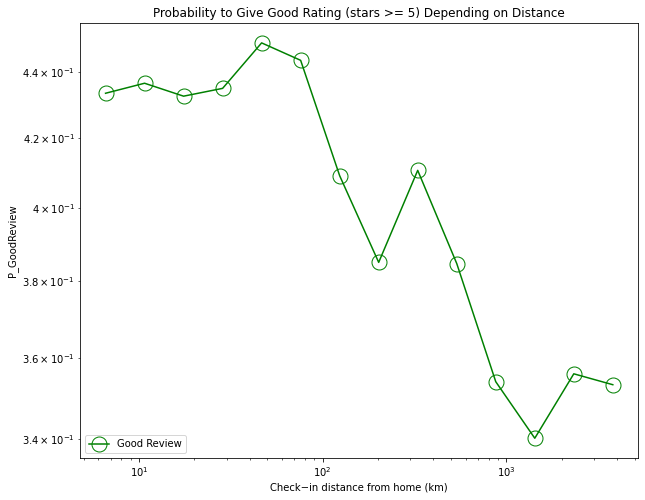

In [161]:
# Plot result
plt.figure(figsize=(10,8)) 
plt.plot(binsCentered,goodUserReview/totalReview,'go', linestyle="-", fillstyle="none", markersize=15,label='Good Review')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Check−in distance from home (km)")
plt.ylabel("P_GoodReview")
plt.legend(loc="lower left")
plt.title("Probability to Give Good Rating (stars >= 5) Depending on Distance")

**Observations of the plot**    
It appears that our intuition was not totally correct.    
First, we can see that from 0 to 100 km, the more we travel away from home, the greater the probability to travel to a good rated business increase. However, past the 100 km mark, this probability decreases quite sharply (with respect to difference observes across the entire graph).    
So it would appear that there is a breakpoint after which our satisfication does not increase. 

### Study the probability of moving to a good rated business depending on the distance from home
One problem with the previous figure was that it might be dependent on the actual current review of each places. Meaning, that it might very well be that up-to 100km users are increasingly travelling to good rated businesses, and past the 100km mark, they enter in less known area, and go to businesses less prestigious.    
Thus, we will plot the probability to move to a well rated place (i.e with rating equal to 5) depending on the distance travel. 


In [46]:
# Select rows for good reviews and bad reviews
df_goodPlaceReviews = df_complete[df_complete['actual_stars'] >= 5]
df_badPlaceReviews = df_complete[df_complete['actual_stars'] <= 2]

In [47]:
# Compute good reviews and bad reviews for each group
goodPlaceReview = df_goodPlaceReviews['review_id'].groupby(pd.cut(df_goodPlaceReviews['distance'], bins=bins)).count()
badPlaceReview = df_badPlaceReviews['review_id'].groupby(pd.cut(df_badPlaceReviews['distance'], bins=bins)).count()

Plot the result.

Text(0.5, 1.0, 'Probability to go to Good Rated (stars >= 5) Place Depending on Distance')

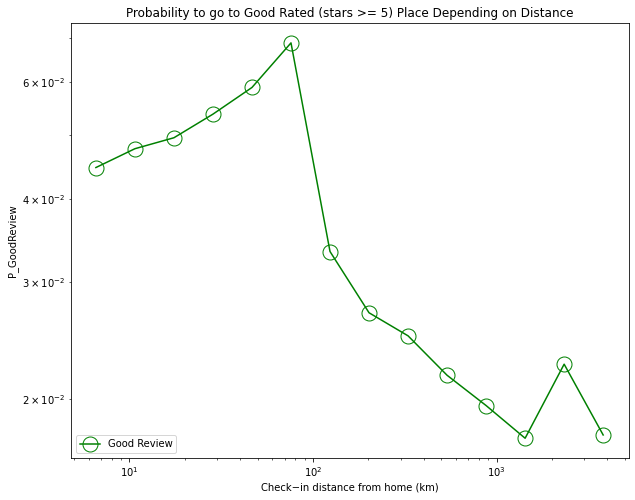

In [160]:
# Plot the result
plt.figure(figsize=(10,8)) 
plt.plot(binsCentered,goodPlaceReview/totalReview,'go', linestyle="-", fillstyle="none", markersize=15,label='Good Review')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Check−in distance from home (km)")
plt.ylabel("P_GoodReview")
plt.legend(loc="lower left")
plt.title("Probability to go to Good Rated (stars >= 5) Place Depending on Distance")

**Observations of the plot**     
We observe the similar behavour on this plot than on the latter plot: the probability that a user travels to a well rated place increases up-to the 100 km mark. After that mark, the probability to travel to a well-rated business falls sharlpy.    
So it appears that our analysis was correct: the probability to give a good review depending on distance has a similar trend than the probability to go to a good reviewed place. Hence, people are more incline to give good review only because they went to better reviewed place.     
However, the final conclusion is that up-to 100 km, the probability that a user travels to a good rated place increases with the distance travelled. Passed the 100 km mark, that probability decreases. 

#### Mean rating of visited places depending on distance 

In [52]:
meanActualStars = df_complete[['review_id', 'actual_stars']].groupby(pd.cut(df_complete['distance'], bins=bins))['actual_stars'].mean()
meanGivenStars = df_complete[['review_id', 'stars']].groupby(pd.cut(df_complete['distance'], bins=bins))['stars'].mean()

Text(0.5, 1.0, 'Mean Business rating Depending on Distance')

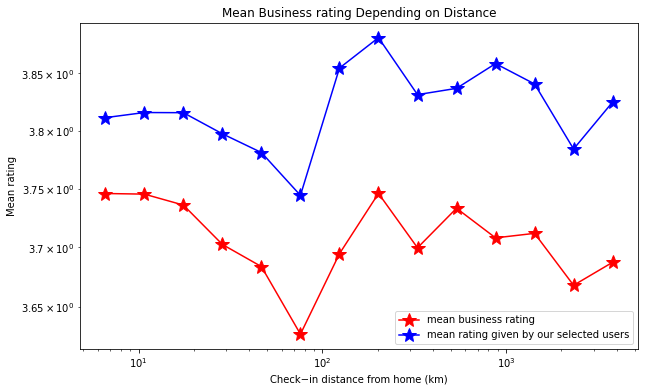

In [156]:
plt.figure(figsize=(10,6)) 
plt.plot(binsCentered,meanActualStars,'r*', linestyle="-", markersize=15,label='mean business rating')
plt.plot(binsCentered,meanGivenStars,'b*', linestyle="-", markersize=15,label='mean rating given by our selected users')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Check−in distance from home (km)")
plt.ylabel("Mean rating")
plt.legend(loc="lower right")
plt.title("Mean Business rating Depending on Distance")

**Observations of the plot**     
We observe that across all distances, the mean rating is always around 3.8. This conforts our decision to choose "good rating" as a 5-stars rating and "bad rating" as a 2-stars or less rating.     
If there is a real incentive to move far (or to not move far), these two type of ratings should encapsulate it. 

## Words of mouth impact

In this section, we want to study friends' ratings influence on mobility with respect to traveling distances. Namely, we study whether friends' ratings can inflence on our mobility, and if yes, how?

### Get the reviewed label

To start, we distribute a `reviewed label` to each review, which is prepared for later use. The `reviewed label` is used to mark whether the business of the review have been reviewd by at least one of user's friends. If yes, whether her friend had given a good rating or not. <br>
We decide to assign 0 to `reviewed label` if no user's friend had reviewed the same business as user, 1 if at least one user's friend had reviewed the same business and gave a bad rating (i.e. rating strictly smaller than 3) and 2 if at least one user's friend had reviewed the same business and gave a good rating (i.e. rating strictly greater than 4).

In [89]:
# Convert date to datatime object
df_reviews["date"] = pd.to_datetime(df_reviews.date.values)
# Rename columns
df_reviews = df_reviews.rename({"stars" : "rating", "average_stars" : "average_rating"},axis=1)
# Group by user_id and business_id and return the corresponding date and rating
df_reviews_groupedUser = df_reviews.groupby(["user_id","business_id"])[["date","rating"]].agg(list)
# Show an example
df_reviews_groupedUser.head()

date rating
user_id                business_id                                         
---1lKK3aKOuomHnwAkAow --9e1ONYQuAa-CB_Rrw7Tw  [2008-11-11 04:40:05]    [4]
                       -ErwgUmZ1-jHW_rSu55jlg  [2010-11-09 20:21:52]    [5]
                       0YhT9HCBkU394IG6tQVtNQ  [2012-05-01 16:17:54]    [1]
                       1JgaRBX0oiRsvEhHF3ZMjw  [2011-02-16 03:58:48]    [1]
                       1Vn_lex3LGGwuTo-xeJnww  [2011-02-16 04:16:12]    [5]

In [90]:
# Group by user_id and business
level_user_id = df_reviews_groupedUser.groupby(level='user_id')

# Create a dictionary of (user_id, business) → list of date and ratings of the business done by user
user_business_date_dict = {}
for idx, data in level_user_id:
    user_business_date_dict[idx] = {}
    for row_index, row in data.iterrows():
        user_business_date_dict[idx][row_index[1]] = (row.date,row.rating)

In [93]:
friends_dict = df_selectedUsers.set_index("user_id")["friend_list"].to_dict()

In [94]:
def get_visit_label(user_id,business_id,date_user):
    """
        Check whether the business has been reviewed by user's friends or not 
        user_id: id of user
        business_id: id of business
        date_user: date of review
        Returns: rating of the user itself if a friend has left a good review in the same place before,
                 -1 otherwise
    """
    # Takes a row of the shape ["user_id","business_id","date"]
    
    # Get friend list of user:
    friends = friends_dict.get(user_id)
    for friend_id in friends:
        friend_dates_rating = user_business_date_dict.get(friend_id, {}).get(business_id)
        if(friend_dates_rating != None):
            for date,rating in zip(friend_dates_rating[0],friend_dates_rating[1]):
                if(date < date_user):
                    return rating
    return -1

# Vectorize the function
get_visit_label_vec = np.vectorize(get_visit_label)

In [98]:
# Select useful columns
selected_reviews_array = np.array(df_selectedReviews[["user_id","business_id","date"]])

In [101]:
# Compute ratings if reviewed by a friend before
df_selectedReviews["reviewed_by_friend_before"] = get_visit_label_vec(selected_reviews_array[:,0],selected_reviews_array[:,1],selected_reviews_array[:,2])

In [9]:
def set_label(rating):
    """
        Determine the visit label for each review
        rating: rating of business
        Return: 2 if a friend has left a good review (bigger than 4),
                1 if a friend has left a bad review (smaller than 3),
                0 otherwise
    """
    if rating < 0:
        return 0
    elif rating < 3:
        return 1
    elif rating > 4:
        return 2
    else :
        return 0

Since those computations are quite heavy, we reload the previously computed labels contaning the rating if a business was reviwed by a friend before.

In [38]:
selected_reviews_full_info = pd.read_csv('./data/selectedReviewsLabel.csv')

In [40]:
#Taking the information we need for the following section
df_selectedReviews["reviewed_by_friend_before"] = selected_reviews_full_info["reviewed_by_friend_before"]
df_selectedReviews["square_id"] = selected_reviews_full_info["square_id"]
df_selectedReviews["dist_checkin_home"]= selected_reviews_full_info["dist_checkin_home"]
df_selectedReviews["week_day"]= selected_reviews_full_info["week_day"]

In [44]:
df_selectedReviews.sample(2)

,review_id,user_id,business_id,rating,date,latitude,longitude,categories,average_rating,Construction,...,Entertainment,RealEstate,Automotive,Food,Miscellaneous,Health,reviewed_by_friend_before,square_id,dist_checkin_home,week_day
2224411,m2NRJL_tWRTtsJoOEPr4PA,xdSh3Mjwuq3LWD85su8NKw,g4h7tTyZGqtP-If4ZAoCKA,2,2010-11-03 11:44:12,43.517793,-79.691673,"['Restaurants', 'Sushi Bars', 'Japanese']",2.0,False,...,False,False,False,True,False,False,-1,193_-257,33.151050,2
448179,qRoK3nIhkB5aCOV4M70qFQ,dzhdfLAY0VNq004_qsxzdg,poYsvuOmVDqF4dTnjJ780A,5,2017-06-28 05:55:09,36.116650,-115.138753,"['Juice Bars & Smoothies', 'Breakfast & Brunch...",4.5,False,...,False,False,False,True,False,False,5,160_-413,1.901923,2


In [45]:
# Assign label to each review
# 2 if a friend of user has left a good review,
# 1 if a friend of user has left a bad review,
# 0 otherwise
df_selectedReviews["review_label"] = df_selectedReviews["reviewed_by_friend_before"].apply(set_label)

### Study friends' ratings influence on mobility

Only checkins of the business where at least one of user's friends have been a reviewed before are studied. We aim to compute the probability to move to a well reviewed (by our friends) business with respect to distance, and the probability to move to a badly reviewed (by our friends) business with respect to distance, and finally, compare the results.

In [51]:
# Work on a copy
newframe = df_homes[['user_id']].copy()
# Create a tuple of (latitude,longitude) for each check-in
newframe['latlong'] = list(zip(df_homes['latitude_home'],df_homes['longitude_home']))
# Create the dictionary mapping from cell_id to all check-ins done in the cell
dict_user_home = newframe.groupby('user_id')['latlong'].apply(list).to_dict()

In [156]:
# List all distances between check-in location and user's home
distances = df_selectedReviews['dist_checkin_home'].values
# Prepare the distance groups for the plot
number_distance_groups = 10
# Define interval of travelling distance
interval_dist_min = 0.1
interval_dist_max = max(distances)
# Define non linear distance intervals
interval_dist = np.geomspace(interval_dist_min , interval_dist_max, number_distance_groups)

In [183]:
# Compute id of distance group for each review (splitting check-ins into buckets)
df_selectedReviews['id_groups'] = df_selectedReviews['dist_checkin_home'].apply(lambda x: bisect(interval_dist, x))
# Show an example
df_selectedReviews.head(2)

,Unnamed: 0,review_id,user_id,business_id,stars_x,date,latitude,longitude,stars_y,reviewed_by_friend_before,square_id,dist_checkin_home,week_day
0,1,t7xOZF5UKXjSpVcXLOSAgw,owbC7FP8SNAlwv6f9S5Stw,-MhfebM0QIsKt87iDN-FNw,2,2014-03-14 08:24:25,36.112896,-115.177637,3.5,-1,160_-413,3.490097,4
1,2,MimB5Xh85rG7phUMPrShag,v9vGnjphb0Hta0lvtf5haA,-MhfebM0QIsKt87iDN-FNw,3,2015-10-07 22:16:59,36.112896,-115.177637,3.5,-1,160_-413,1.435575,2


In [159]:
def compute_fractions(df,number_distance_groups):
    """
        Compute the popability of travelling(recommended (or not) by at least one friend) as a funtion of distance travelled
        df: dataframe
        number_distance_groups: number of distance groups
        Return: porbability that user travels with/without friends' recommendation as a function of distance
    """
    # Group the dataframe by id_groups and review label
    grouped = df.groupby(['id_groups','review_label']).count()['user_id'].reset_index()
    # Count the numbers of each label in the same group
    grouped.rename(columns = {'user_id':'counts'},inplace=True)
    # Create a dictionary mapping from (group_id, label) to the number of counts
    dict_group_revlabel = grouped.groupby(['id_groups','review_label'])['counts'].apply(list).apply(np.squeeze).to_dict()
    
    # Initialize arrays
    good_reviews = []
    bad_reviews = []
    
    # For all groups
    for group_id in range(number_distance_groups):
        # Find all reviews in the group
        target_rows = np.where(df['id_groups']==group_id)[0]
        tot = float(len(target_rows))
        if(tot==0):
            # When there is no review for this group, append 0 to the fraction
            good_reviews.append(0)
            bad_reviews.append(0)
        else:
            # Count the number of recommended and not recommended reviews within the group
            group_good = (dict_group_revlabel.get((group_id,2))or 0)
            group_bad = (dict_group_revlabel.get((group_id,1))or 0)
            # Compute the porbability that user travels with/without friends' recommendation
            good_reviews.append(group_good/tot) 
            bad_reviews.append(group_bad/tot)
            
    return good_reviews,bad_reviews

In [160]:
# Compute the popability of travelling(recommended (or not) by at least one friend) as a funtion of distance travelled
good_reviews,bad_reviews = compute_fractions(df_selectedReviews,number_distance_groups)

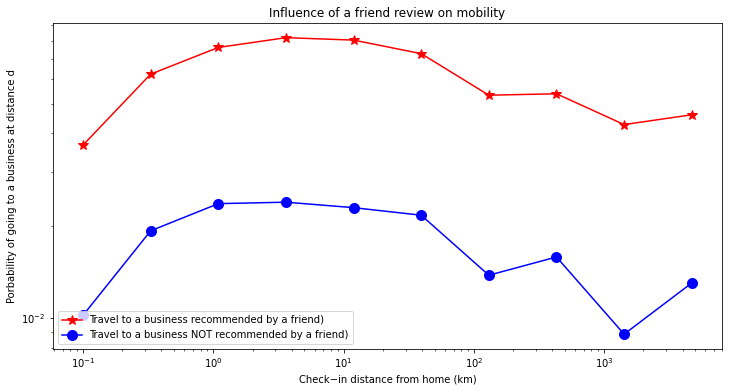

In [161]:
# Plot the result
plt.figure(figsize=(12, 6))
# What I obtain previously, with the first P_null
#plt.subplot(121)
plt.plot(interval_dist,good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
plt.plot(interval_dist,bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Porbability of going to a business at distance d")
plt.xlabel("Check−in distance from home (km)")
plt.legend(loc="lower left")
plt.title("Influence of a friend review on mobility")

plt.show()

##### Discussion:

This plot shows for each distance, the proportion of check-ins that were made after a friend left a good review (red curve) or after a friend left a bad review (blue curve) over all check-ins. We can as expected see that there is a gap between the two curves, the probablty of going to a business well rated by friends is higher than the probability of going to a business not well rated. Now seeing how these curves evolve over the distance is interesting, as both probabilities go higher for the first ten kilometers from home, before going back down. So as the distance gets bigger, a friends influence gets smaller (at least when it comes to well rated businesses by friends). For the blue curve, the probability that someone goes to a business after it was badly rated by a friend gets smaller, which could be explained by the influence of the friends review but probably because we have less friends as the distance gets bigger so less reviews to get influenced by.

## Week day study
In this section, we aim to study the pattern of humain mobility depending on week day. To do so, all reviews are grouped by week day, then the probability of travelling as a function of distance travelled is computed for each day of the week.

In [67]:
# Apply weekday() to each date in the dataframe
df_selectedReviews["week_day"]=df_selectedReviews.date.apply(lambda x : x.weekday())

In [68]:
def compute_fractions_week(df,number_distance_groups):
    """
        For each day of the week, compute the popability of travelling as a funtion of distance travelled
        df: dataframe
        number_distance_groups: number of distance groups
        Return: porbability that user travels as a function of distance for each day
    """
    # Group the dataframe by id_groups and week day
    grouped = df.groupby(['id_groups','week_day']).count()['user_id'].reset_index()
    # Count the numbers of each label in the same group
    grouped.rename(columns = {'user_id':'counts'},inplace=True)
    # Create a dictionary mapping from (group_id, week day) to the number of counts
    dict_group_revlabel = grouped.groupby(['id_groups','week_day'])['counts'].apply(list).apply(np.squeeze).to_dict()
    
    # Initialize arrays
    mon_reviews = []
    tue_reviews = []
    wed_reviews = []
    thu_reviews = []
    fri_reviews = []
    sat_reviews = []
    sun_reviews = []
    
    # For all groups
    for group_id in range(number_distance_groups):
        # Find all reviews in the group
        target_rows = np.where(df['id_groups']==group_id)[0]
        tot = float(len(target_rows))
        if(tot==0):
            # When there is no review for this group, append 0 to the fraction
            good_reviews.append(0)
            bad_reviews.append(0)
        else:
            # Count the number of reviews for each week day within the group
            group_mon = (dict_group_revlabel.get((group_id,0))or 0)
            group_tue = (dict_group_revlabel.get((group_id,1))or 0)
            group_wed = (dict_group_revlabel.get((group_id,2))or 0)
            group_thu = (dict_group_revlabel.get((group_id,3))or 0)
            group_fri = (dict_group_revlabel.get((group_id,4))or 0)
            group_sat = (dict_group_revlabel.get((group_id,5))or 0)
            group_sun = (dict_group_revlabel.get((group_id,6))or 0)
            # Compute the porbability that user travels as a function of distance for each day
            mon_reviews.append(group_mon/tot) 
            tue_reviews.append(group_tue/tot)
            wed_reviews.append(group_wed/tot)
            thu_reviews.append(group_thu/tot)
            fri_reviews.append(group_fri/tot)
            sat_reviews.append(group_sat/tot)
            sun_reviews.append(group_sun/tot)
            
    return mon_reviews,tue_reviews,wed_reviews,thu_reviews,fri_reviews,sat_reviews,sun_reviews

In [69]:
# Compute fractions for all week days
mon_reviews,tue_reviews,wed_reviews,thu_reviews,fri_reviews,sat_reviews,sun_reviews = compute_fractions_week(df_selectedReviews_v2,number_distance_groups)

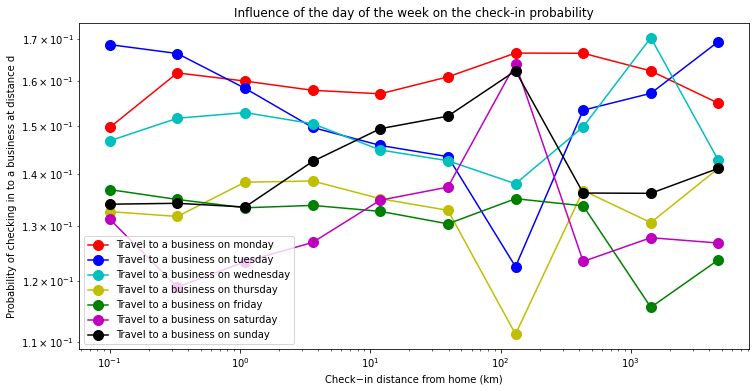

In [148]:
# Plot the result
plt.figure(figsize=(12, 6))
# What I obtain previously, with the first P_null
#plt.subplot(121)
plt.plot(interval_dist,mon_reviews,'ro-', markersize=10,label='Travel to a business on monday')
plt.plot(interval_dist,tue_reviews,'bo-', markersize=10,label='Travel to a business on tuesday')
plt.plot(interval_dist,wed_reviews,'co-', markersize=10,label='Travel to a business on wednesday')
plt.plot(interval_dist,thu_reviews,'yo-', markersize=10,label='Travel to a business on thursday')
plt.plot(interval_dist,fri_reviews,'go-', markersize=10,label='Travel to a business on friday')
plt.plot(interval_dist,sat_reviews,'mo-', markersize=10,label='Travel to a business on saturday')
plt.plot(interval_dist,sun_reviews,'ko-', markersize=10,label='Travel to a business on sunday')
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Probability of checking in to a business at distance d")
plt.xlabel("Check−in distance from home (km)")
plt.legend(loc="lower left")
plt.title("Influence of the day of the week on the check-in probability")

plt.show()

##### Discussion:

We had excpected that on week-ends, the probability that a user travels further would get higher, which we can in part observe here: for Saturday, Sunday and Monday, the probability does get higher until the 100km mark then goes back down (which does make some sense). But for week days, the probability goes down for the first 100km but then goes back up (except for Friday), which could indicate that during week days, if someone travels far it's probably to go further than 100km (we could imagine some kind of business trip or vacation).

### Influence of friend's reviews depending on week day

We will now see if the influence of a user's friend's good and bad reviews evolves depending on the day of the week. Intuitively we would expect that on week-end, user's are more likely to move further away than during a week day following a friend's good review. Let's see how it actually is:

In [149]:
# Fetch reviews by week day
mon_checkins = df_selectedReviews[df_selectedReviews["week_day"] == 0]
tue_checkins = df_selectedReviews[df_selectedReviews["week_day"] == 1]
wed_checkins = df_selectedReviews[df_selectedReviews["week_day"] == 2]
thu_checkins = df_selectedReviews[df_selectedReviews["week_day"] == 3]
fri_checkins = df_selectedReviews[df_selectedReviews["week_day"] == 4]
sat_checkins = df_selectedReviews[df_selectedReviews["week_day"] == 5]
sun_checkins = df_selectedReviews[df_selectedReviews["week_day"] == 6]

In [150]:
# Compute fractions for each week day
mon_good_reviews,mon_bad_reviews = compute_fractions(mon_checkins,number_distance_groups)
tue_good_reviews,tue_bad_reviews = compute_fractions(tue_checkins,number_distance_groups)
wed_good_reviews,wed_bad_reviews = compute_fractions(wed_checkins,number_distance_groups)
thu_good_reviews,thu_bad_reviews = compute_fractions(thu_checkins,number_distance_groups)
fri_good_reviews,fri_bad_reviews = compute_fractions(fri_checkins,number_distance_groups)
sat_good_reviews,sat_bad_reviews = compute_fractions(sat_checkins,number_distance_groups)
sun_good_reviews,sun_bad_reviews = compute_fractions(sun_checkins,number_distance_groups)

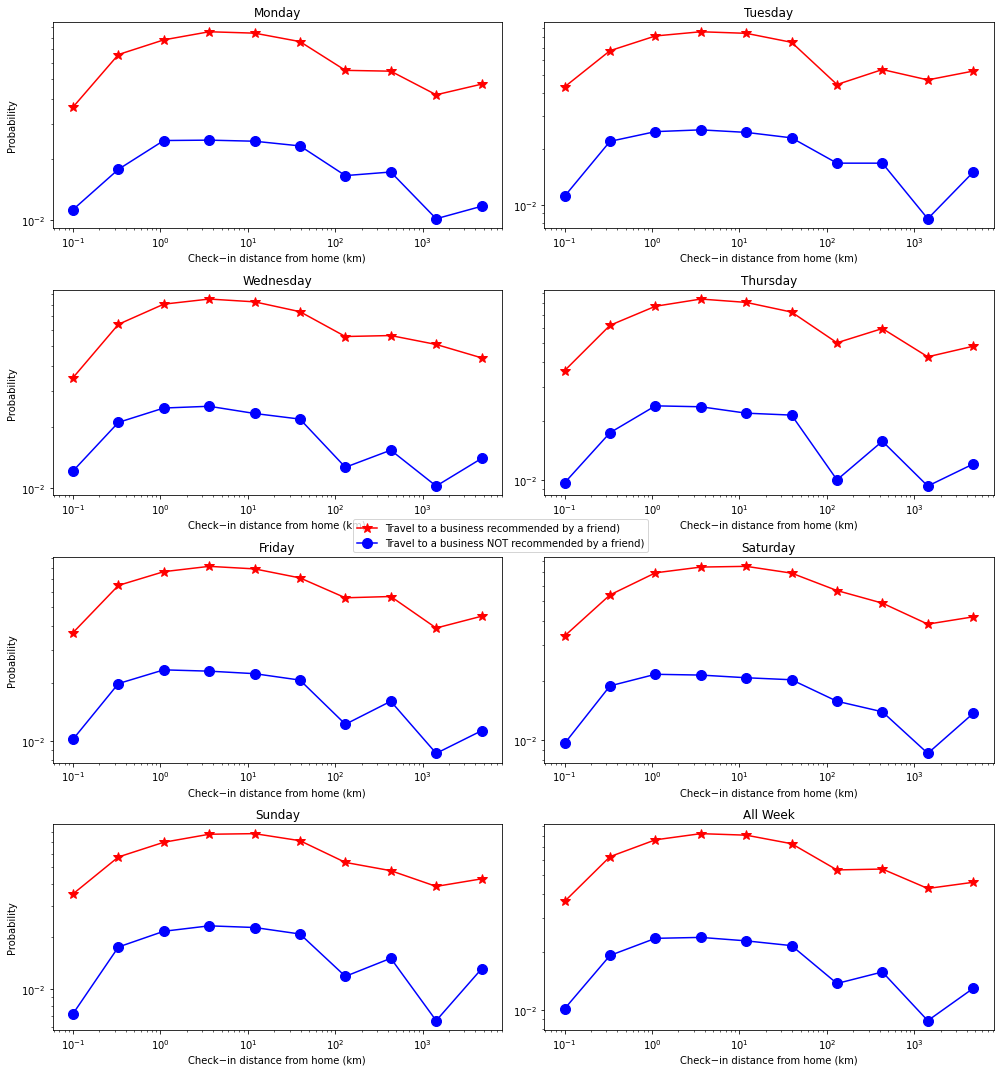

In [151]:
# Plot the result
f, ax = plt.subplots(4, 2, figsize=(14, 15))
ax[0,0].plot(interval_dist,mon_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[0,0].plot(interval_dist,mon_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel("Probability")
ax[0,0].set_xlabel("Check−in distance from home (km)")
ax[0,0].set_title("Monday")

ax[0,1].plot(interval_dist,tue_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[0,1].plot(interval_dist,tue_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel("Check−in distance from home (km)")
ax[0,1].set_title("Tuesday")

ax[1,0].plot(interval_dist,wed_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[1,0].plot(interval_dist,wed_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel("Probability")
ax[1,0].set_xlabel("Check−in distance from home (km)")
ax[1,0].set_title("Wednesday")

ax[1,1].plot(interval_dist,thu_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[1,1].plot(interval_dist,thu_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel("Check−in distance from home (km)")
ax[1,1].set_title("Thursday")

ax[2,0].plot(interval_dist,fri_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[2,0].plot(interval_dist,fri_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[2,0].set_xscale('log')
ax[2,0].set_yscale('log')
ax[2,0].set_ylabel("Probability")
ax[2,0].set_xlabel("Check−in distance from home (km)")
ax[2,0].set_title("Friday")

ax[2,1].plot(interval_dist,sat_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[2,1].plot(interval_dist,sat_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[2,1].set_xscale('log')
ax[2,1].set_yscale('log')
ax[2,1].set_xlabel("Check−in distance from home (km)")
ax[2,1].set_title("Saturday")

ax[3,0].plot(interval_dist,sun_good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[3,0].plot(interval_dist,sun_bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[3,0].set_xscale('log')
ax[3,0].set_yscale('log')
ax[3,0].set_ylabel("Probability")
ax[3,0].set_xlabel("Check−in distance from home (km)")
ax[3,0].set_title("Sunday")

ax[3,1].plot(interval_dist,good_reviews,'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[3,1].plot(interval_dist,bad_reviews,'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[3,1].set_xscale('log')
ax[3,1].set_yscale('log')
ax[3,1].set_xlabel("Check−in distance from home (km)")
ax[3,1].set_title("All Week")
f.tight_layout()

handles, labels = ax[0,0].get_legend_handles_labels()
f.legend(handles, labels, loc='center')

##### Discussion:
Unfortunately, this is not giving us much more information. We can see that plot for all seven days of the week are pretty similar to our original plot for friends's reviews influence. It seems that the day of the week doesn't have much impact on friend's influence on check-ins.

### Category study
In this section, we aim to study whether depending on the category, the influence of friend's review changes. We excpect some differences, even though a friend gave a great review to this real sport center very far from my home, I'm still not very likely to go there, since I can find one closer to my place. However, if a friend gave a great review to one a restaurant far away from my house, then I still might go there.

In [152]:
# Fetch all categories
categories = df_selectedReviews.columns[9:26]
categories

Index(['Construction', 'Computers', 'Home', 'Merchant', 'Manufacturing',
       'Travel', 'Sport', 'Education', 'Legal', 'BusinessSupport',
       'PersonalCare', 'Entertainment', 'RealEstate', 'Automotive', 'Food',
       'Miscellaneous', 'Health'],
      dtype='object')

In [101]:
# Work on a copy
df_selectedReviews_cat = df_selectedReviews.copy()

In [153]:
# Let's do the same but now over all reviews
# Let's get for each categories, the corresponding check-ins
check_in_per_category = []
for cat in categories:
    check_in_per_category.append(df_selectedReviews_cat[df_selectedReviews_cat[cat] == True].drop(categories,axis = 1))

In [154]:
# For each category, get the fractions of good and bad reviews
good_bad_reviews_cat = []
for df in check_in_per_category:
    good_bad_reviews_cat.append(compute_fractions(df,number_distance_groups))
good_bad_reviews_cat.append(compute_fractions(df_selectedReviews_cat,number_distance_groups))

Text(0.5, 1.0, 'All categories')

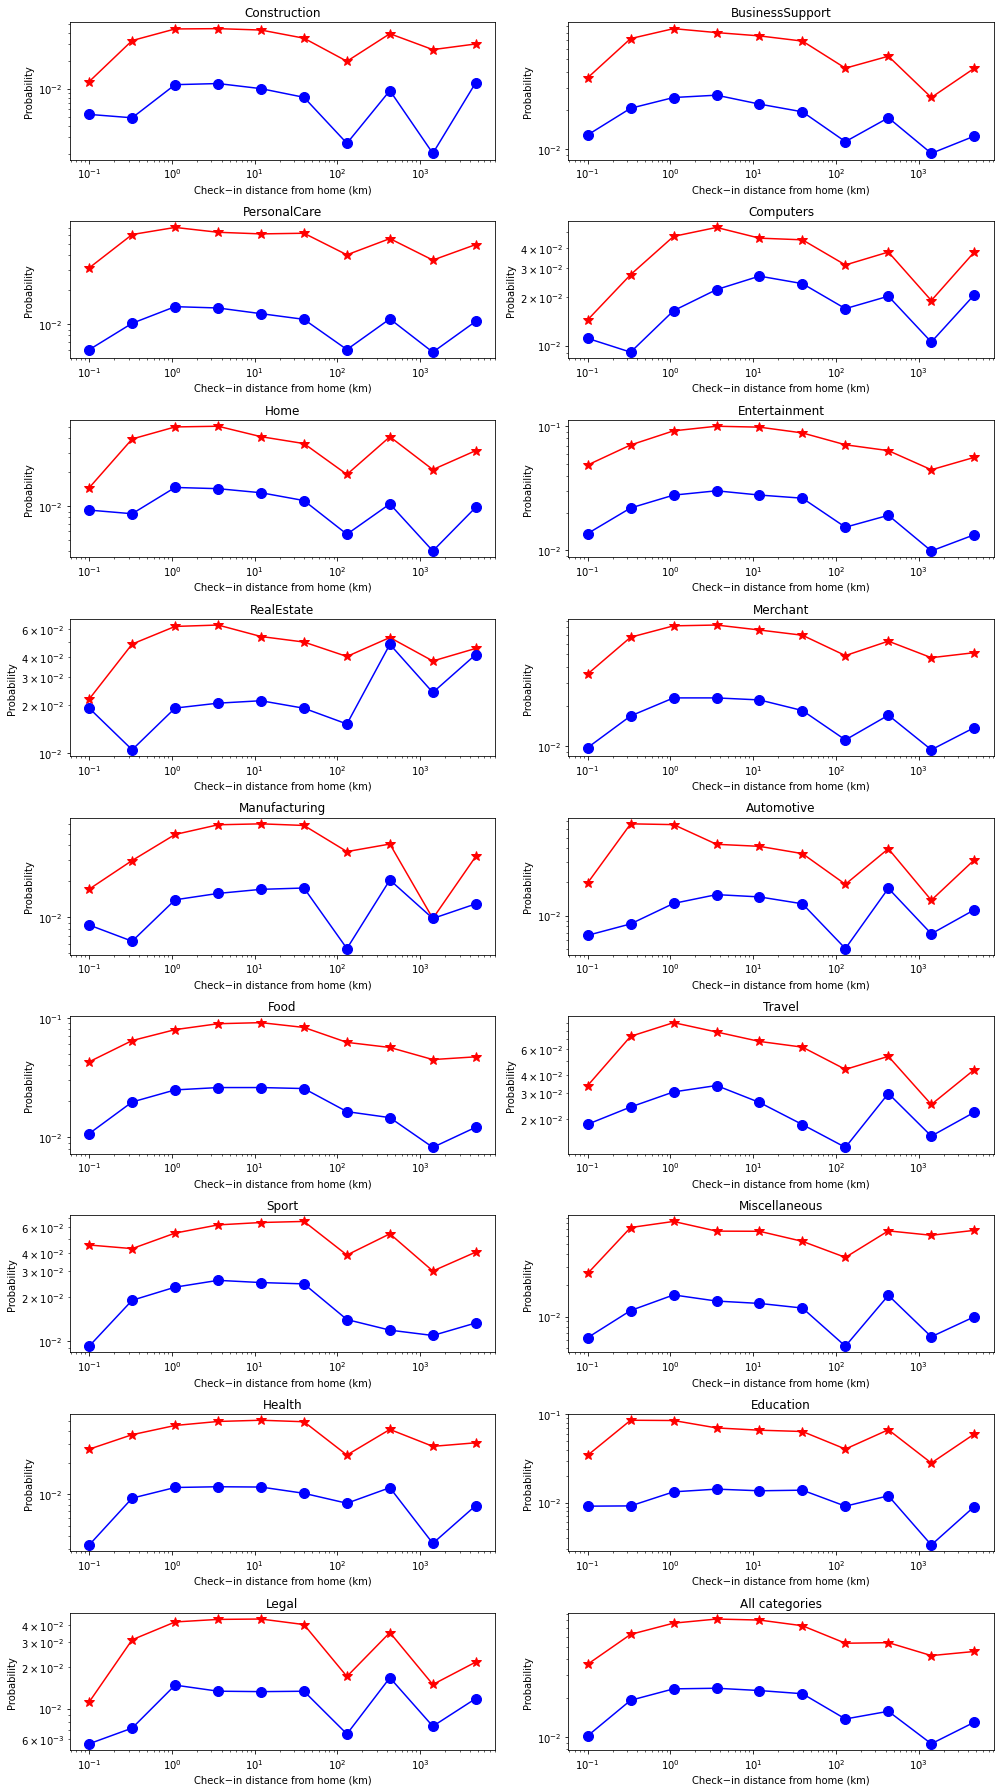

In [155]:
# Plot the result
f, ax = plt.subplots(9, 2, figsize=(14, 25))
i = 0
for cat in categories:
    ix = i%9
    iy = i%2
    ax[ix,iy].plot(interval_dist,good_bad_reviews_cat[i][0],'r*-', markersize=10,label='Travel to a business recommended by a friend)')
    ax[ix,iy].plot(interval_dist,good_bad_reviews_cat[i][1],'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
    ax[ix,iy].set_xscale('log')
    ax[ix,iy].set_yscale('log')
    ax[ix,iy].set_ylabel("Probability")
    ax[ix,iy].set_xlabel("Check−in distance from home (km)")
    ax[ix,iy].set_title(cat)
    i += 1

ax[8,1].plot(interval_dist,good_bad_reviews_cat[i][0],'r*-', markersize=10,label='Travel to a business recommended by a friend)')
ax[8,1].plot(interval_dist,good_bad_reviews_cat[i][1],'bo-', markersize=10,label='Travel to a business NOT recommended by a friend)')
ax[8,1].set_xscale('log')
ax[8,1].set_yscale('log')
ax[8,1].set_ylabel("Probability")
ax[8,1].set_xlabel("Check−in distance from home (km)")
f.tight_layout()
ax[8,1].set_title('All categories')

##### Discussion:
This on the other hand does give us some more intersting insights. Depending on the categories the influence of bad and good friends reviews changes. We will not go over all categories but let's note a few intersting tendencies. 
The most intersting plots are for the categories Real Estate and Manufacturing, where both the probabilities of doing a check in after a good friend review and bad friend review get really close to each other as distance gets higher. This means that as distance gets higher the opinion of a friend on a business isn't really important. We could see this as: even if the friend reviews are (or bad), if there are too far, some type of business are not worth the long distance travelling, which is understandable for Real Estate or Manufacturing.
The categories with the biggest gaps between the two curves are Food and Entertainment, meaning that the friends opinion have the most influence here, regardless of the distance, which is what we would have expceted for those two categories. Indeed, food and entertainment particularly, if well reviewed by friends, are more likely to make people move further: if an excellent restaurant or a great escape game a friend recommended is far away, the user still might go (when it wouldn't really if the friend gave bad reviews).

##  Well rated business and poorely rated buisnesses
Do well rated business have a greater visitorship then poorely rated buisnesses? (Obersvational Studies)

### Distribution of the number of visits of well rated places vs badly rated places
We will first try to understand if a well rated business attracts more people than badly rated businesses.

In [82]:
# Recall business dataframe
df_business.head(2)

,business_id,state,latitude,longitude,categories,stars,state,Sport,Computers,Entertainment,...,Miscellaneous,Home,PersonalCare,RealEstate,Legal,Health,Travel,Automotive,Food,Merchant
0,f9NumwFMBDn751xgFiRbNA,NC,35.462724,-80.852612,"[Active Life, Gun/Rifle Ranges, Guns & Ammo, S...",3.5,NC,False,False,True,...,False,False,True,False,False,False,False,False,False,True
1,Yzvjg0SayhoZgCljUJRF9Q,AZ,33.569404,-111.890264,"[Health & Medical, Fitness & Instruction, Yoga...",5.0,AZ,True,False,False,...,False,False,True,False,False,True,False,False,False,False


In [83]:
# Fetch all categories of business
df_categories['category'])

In [84]:
# Merge dataframes
df_checkinsCategory = pd.merge(df_reviews, df_selectedUsers, left_on='user_id', right_on='user_id', how='right')
df_checkinsCategory = pd.merge(df_checkinsCategory, df_business, left_on='business_id', right_on='business_id', how='inner')
# Drop useless columns 
df_checkinsCategory = df_checkinsCategory.drop(['longitude_x', 'longitude_y','friend_list', 'categories_y', 'latitude', 'longitude', 'categories_x', 'latitude_y', 'date', 'latitude_x', 'longitude_home', 'latitude_home', 'state', 'categories'], axis=1)

In [121]:
# stars_y is duplicate name
changeName = df_checkinsCategory.columns.values
changeName[4] = "mean_rating"
df_checkinsCategory.columns = changeName
df_checkinsCategory = df_checkinsCategory.drop('stars_y', axis=1)

In [126]:
# Compute treated and control values
treated = df_checkinsCategory[df_checkinsCategory['mean_rating'] >=4].groupby('business_id').count()['review_id']
control = df_checkinsCategory[df_checkinsCategory['mean_rating'] <=2].groupby('business_id').count()['review_id']

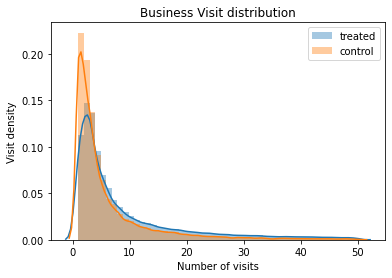

In [129]:
# Plot the result
ax = sns.distplot(treated[treated <= 50], hist=True, label='treated');
ax = sns.distplot(control[control <= 50], hist=True, label='control')
ax.set(title='Business Visit distribution',xlabel='Number of visits', ylabel='Visit density')
plt.legend()
plt.show()

In [176]:
# Create figure
fig = ff.create_distplot([treated[treated <= 50], control[control <= 50]], ['Treated', 'Control'], bin_size=.2, colors=colors,  show_hist=False, show_rug=False)
fig.update_layout(title_text='Distribution of the number of visits of businesses')
# Send the figure to the server
username = 'PM_EPFL' 
api_key = 'mhSnWR5XdSgJaEB24BH4' 
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)
py.plot(fig, filename = 'dist_visit', auto_open=True)

'https://plotly.com/~PM_EPFL/8/'

In [179]:
# Plot the result
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']
fig = ff.create_distplot([treated[treated <= 50], control[control <= 50]], ['Treated', 'Control'], bin_size=.2, colors=colors,  show_hist=False, show_rug=False)
fig.update_layout(title_text='Distribution of the number of visits of businesses')
fig.show()

<img src="./images/global.png">

**NB: we can't save plotty figure into the memory of the notebook, we we've displayed snapshots of the actual figure. The interactive figure can be found on our website***

In [141]:
print("The mean number of vists of well rated businesses is ", np.mean(treated), "and the median is", np.median(treated))
print("The mean number of visits of bad rated businesses is:", np.mean(control), "and the median is", np.median(control))

The mean number of vists of well rated businesses is  27.34777793461384 and the median is 6.0
The mean number of visits of bad rated businesses is: 7.594013529793346 and the median is 3.0


***Discussion***     
It appears that businesses with better grade have an advandage. We can see that buisnesses well rated vs the badly rated businesses have the same pareto distribution, but the one of well rated businesses is slightly shiffted toward bigger number of visits. Hence, it would appear that businesses with a high rating are more visited. 
This observation is also cooborated by the median and mean of each of the distribution. 

However, from the course, we know that we canno't jump to conclusion yet, and have to study if businesses used to created this plot are comparable. This is the next goal: get some insight on what are the well-rated businesses and the not-well rated businesses.

## Distribution of checkins accross category

In [143]:
# Count how buisness are distributed among categories
def count_per_category(df):
    df_res = pd.DataFrame(np.array([name for name in categorySet]),columns=['category'])
    categoryCount = np.zeros(len(categorySet))
    for category_name in categorySet:
        categoryCount[indexCategory.get(category_name)] = df[df[category_name]].count()[0]
    df_res['count'] = categoryCount
    return df_res

In [144]:
# Compute the seperation of groups
treatedGroupSeperation = count_per_category(df_checkinsCategory[df_checkinsCategory['mean_rating'] >=4])

<Figure size 720x720 with 0 Axes>

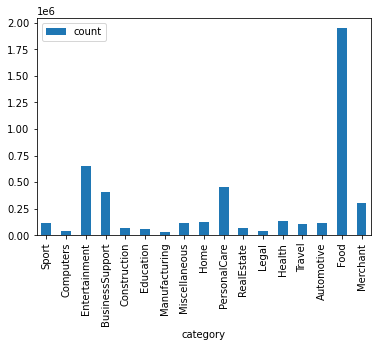

In [145]:
# Plot the result
plt.figure(figsize=(10,10)) 
treatedGroupSeperation.plot.bar(x='category', y='count', rot=90)

In [147]:
# Compute the seperation of groups
controlGroupSeperation = count_per_category(df_checkinsCategory[df_checkinsCategory['mean_rating'] <=2])

<Figure size 720x720 with 0 Axes>

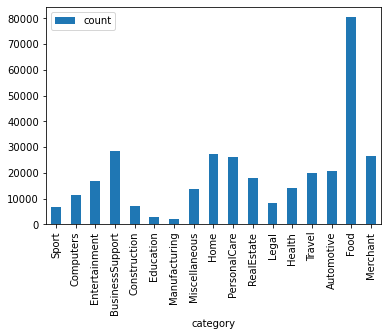

In [148]:
# Plot the result
plt.figure(figsize=(10,10)) 
controlGroupSeperation.plot.bar(x='category', y='count', rot=90)

**Observations on the graph**    
It appears that well rated-buisnesses are mainly represented by restaurant, entertainment businesses and Business Support businesses. On the other hand, differences between category are smaller for the poorly rated businesses: there is still an over-representation of restaurants, but the difference with other type of buisnesses is smaller. 

## Study distribution of number of checkins per business depending on rating and per catagory
In this section, we will compare the treatment (having a good mean rating) against the control (having a bad rating) on businesses that are similar (i.e part of the same category). This is in-line with what was said in the Observational Studies Course. 

In [ ]:
# Load data
df_goodCheckins = pd.read_csv('./data/good_checkins.csv')
df_badCheckins = pd.read_csv('./data/bad_checkins.csv')
df_badCheckins.head(3)

In [ ]:
def set_visible(idx,N):
    """
        Return masks for arrays
        idx: index of arrays
        N: number of all arrays
        Return: mask having the length of arrays. 
                True at position idx and idx+1, False otherwise
    """
    # Create initial mask
    a = np.zeros(2*N)
    # Set True for target indices
    a[2*idx]=True
    a[2*idx+1]=True
    # Create final mask
    a = a>0
    return list(a.copy())

def list_dict_(col_names,N):
    """
        Compute the list of dictionaries for interactive plot
        col_names: columns name of the dataframe, which is used as x-axis for the plot
        N: number of all arrays
        Return: list of dictionaries for interactive plot
    """
    # Initialize the array
    res = []
    
    # Add each week day
    for idx,i in enumerate(col_names): 
        res.append(dict(label=i,
                         method="update",
                         args=[{"visible": set_visible(idx,N)},
                               {"title": i}]))

    return list(res)

In [ ]:
fig = go.Figure()
for i in range(len(col_names)):
    cat1 = col_names[i]

    treated_1 = df_goodCheckins[df_goodCheckins[cat1]].groupby('business_id').count()
    control_1 = df_badCheckins[df_badCheckins[cat1]].groupby('business_id').count()
    treated_1 = treated_1['review_id']
    control_1 = control_1['review_id']

    fig_ = ff.create_distplot([treated_1[treated_1 <= 50], control_1[control_1 <= 50]], ['Treated', 'Control'], bin_size=.2,  show_hist=False,show_rug=False)
    
    fig.add_trace(
        go.Scatter(x=fig_.data[0].x, 
                   y=fig_.data[0].y,
                   name="Treated",
                   line=dict(color="#FF0000")))
    
    fig.add_trace(
        go.Scatter(x=fig_.data[1].x, 
                   y=fig_.data[1].y,
                   name="Control",
                   line=dict(color="#0000FF")))

    # Save html
    #pio.write_html(fig, file=cat1+'.html', auto_open=False)
    
# Add layout
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list_dict_(col_names,len(col_names))
        )
    ])

# Define axies
fig.update_xaxes(title_text="The number of clients")
fig.update_yaxes(title_text="Probability of the number of client the business can have")  
# Set title
fig.update_layout(title_text="Influence of ratings on the number of clients that business can have")
fig.show() 

<img src="./images/realEstate.png">
<img src="./images/food.png">
<img src="./images/entertainment.png">

**NB: we can't save plotty figure into the memory of the notebook, we we've displayed snapshots of the actual figure. The interactive figure can be found on our website***

***Discussion***     
The figure above plots the probability of a buisness to attract n clients. We've plot this probability for businesses that have been well rated (red) and poorly-rated (blue).     
We can that ratings have a lot of influence on businesses that provide food services or entertainement services, whereas businesses such as Real Estate agencies are less influenced by ratings.     
We can thus refine our previously conclusion: having a good review helps certain category of buisnesses, some are imune to bad/good reviews.  



# IV. Data Story
## Codes for intervative plots for data story
Create the interactive plot for the evolution of friends' reviews influence on mobility according to weekdays

In [120]:
# Load dataframes for week day study
df_bad = pd.read_csv('./for_plotting/bad_reviews_week.csv')
df_good = pd.read_csv('./for_plotting/good_reviews_week.csv')
# Show an example
df_good.head()

,mon,tue,wed,thu,fri,sat,sun,allWeekDays,bucket
0,0.036301,0.043127,0.035008,0.036259,0.036784,0.033494,0.035211,0.036605,0.100000
1,0.066043,0.067536,0.064058,0.061815,0.064771,0.053868,0.057454,0.062360,0.330530
2,0.078054,0.081050,0.080477,0.077344,0.076375,0.069528,0.069827,0.076178,1.092500
3,0.085617,0.085395,0.085262,0.084203,0.081403,0.074329,0.077653,0.081993,3.611038
4,0.084256,0.083751,0.082604,0.080948,0.078963,0.074947,0.078276,0.080513,11.935557


In [121]:
# Rename columns names for both dataframes
df_good.rename(columns={'mon':'Monday','tue':'Tuesday','wed':'Wednesday','thu':'Thursday','fri':'Friday','sat':'Saturday','sun':'Sunday'},inplace=True)
df_bad.rename(columns={'mon':'Monday','tue':'Tuesday','wed':'Wednesday','thu':'Thursday','fri':'Friday','sat':'Saturday','sun':'Sunday'},inplace=True)

In [122]:
def set_visible(idx,N):
    """
        Return masks for arrays
        idx: index of arrays
        N: number of all arrays
        Return: mask having the length of arrays. 
                True at position idx and idx+1, False otherwise
    """
    # Create initial mask
    a = np.zeros(2*N)
    # Set True for target indices
    a[2*idx]=True
    a[2*idx+1]=True
    # Create final mask
    a = a>0
    return list(a.copy())

In [123]:
def list_dict(col_names,N):
    """
        Compute the list of dictionaries for interactive plot
        col_names: columns name of the dataframe, which is used as x-axis for the plot
        N: number of all arrays
        Return: list of dictionaries for interactive plot
    """
    # Initialize the array
    res = []
    
    # Plot all weekdays
    res.append(dict(label="Plot all weekdays",
                     method="update",
                     args=[{"visible": list(np.ones(N))},
                           {"title": "Plot all weekdays"}]))
    # Add each week day
    for idx,i in enumerate(col_names): 
        res.append(dict(label=i,
                         method="update",
                         args=[{"visible": set_visible(idx,N)},
                               {"title": i}]))

    return list(res)

In [124]:
# Define distance groups
bucket = df_good['bucket'].values
# Define x axis of the plot
col_names = df_bad.columns[:len(df_bad.columns)-1]

In [ ]:
# Initialize figure
fig = go.Figure()

# Add Traces
for i in col_names:
    fig.add_trace(
    go.Scatter(x=bucket,
               y=df_good[i].values,
               name=i+" good review",
               line=dict(color="#FF0000")))
    fig.add_trace(
    go.Scatter(x=bucket,
               y=df_bad[i].values,
               name=i+" bad review",
               line=dict(color="#0000FF")))

# Add layout
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list_dict(col_names,len(col_names)),
        )
    ])


# Define axies
fig.update_xaxes(title_text="Distance travelled in km by weekday in logarithmic scale", type="log")
fig.update_yaxes(title_text="Probability of travelling") 
# Set title
fig.update_layout(title_text="Evolution of friends' reviews influence on mobility according to weekdays")
fig.show()

In [126]:
# Save html
pio.write_html(fig, file='evolution_weekday.html', auto_open=True)

Create the interactive plot for the evolution of friends' reviews influence on mobility according to categories

In [127]:
# Load dataframes for category study
df_bad_cat = pd.read_csv('./for_plotting/bad_reviews_cat.csv')
df_good_cat = pd.read_csv('./for_plotting/good_reviews_cat.csv')
# Show an example
df_good_cat.head()

,Construction,Computers,Home,Merchant,Manufacturing,Travel,Sport,Education,Legal,BusinessSupport,PersonalCare,Entertainment,RealEstate,Automotive,Food,Miscellaneous,Health,All Categories
0,0.011936,0.014444,0.014615,0.035347,0.017167,0.033902,0.045535,0.034448,0.011161,0.035795,0.031081,0.048737,0.021817,0.019601,0.042929,0.026024,0.026828,0.036605
1,0.032927,0.027411,0.039514,0.067379,0.029827,0.073211,0.043014,0.085977,0.031363,0.071918,0.060781,0.070728,0.048294,0.066355,0.064546,0.072068,0.036810,0.062360
2,0.043876,0.047142,0.050519,0.082257,0.049288,0.090685,0.054936,0.085361,0.042151,0.085851,0.070101,0.091973,0.062287,0.065293,0.079677,0.082501,0.045037,0.076178
3,0.044220,0.053504,0.051243,0.083429,0.059445,0.078351,0.062517,0.070358,0.043982,0.080017,0.063602,0.100211,0.063559,0.043501,0.089292,0.066551,0.049170,0.081993
4,0.042705,0.045966,0.041418,0.076462,0.060533,0.067588,0.064907,0.066298,0.044245,0.075450,0.061568,0.098514,0.053847,0.041706,0.091174,0.066310,0.050503,0.080513


In [128]:
# Define x axis of the plot
col_names_cat = df_bad_cat.columns

In [129]:
def list_dict_cat(col_names_cat,N):
    """
        Compute the list of dictionaries for interactive plot
        col_names_cat: columns name of the category dataframe, 
                        which is used as x-axis for the plot
        N: number of all arrays
        Return: list of dictionaries for interactive plot
    """
    res = []
    
    # For plotting all arrays
    res.append(dict(label="Plot all categories",
                     method="update",
                     args=[{"visible": list(np.ones(N))},
                           {"title": "Plot all categories"}]))
    
    # For plotting arrays indiviually
    for idx,i in enumerate(col_names_cat): 
        res.append(dict(label=i,
                         method="update",
                         args=[{"visible": set_visible(idx,N)},
                               {"title": i}]))
    return list(res)

In [ ]:
# Initialize figure
fig = go.Figure()

# Add Traces
for i in col_names_cat:
    fig.add_trace(
    go.Scatter(x=bucket,
               y=df_good_cat[i].values,
               name=i+" good review",
               line=dict(color="#FF0000")))
    fig.add_trace(
    go.Scatter(x=bucket,
               y=df_bad_cat[i].values,
               name=i+" bad review",
               line=dict(color="#0000FF")))

# Add layout
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list_dict_cat(col_names_cat,len(col_names_cat)),
        )
    ])

# Define axies
fig.update_xaxes(title_text="Distance travelled in km by category in logarithmic scale", type="log")
fig.update_yaxes(title_text="Probability of travelling") 
# Set title
fig.update_layout(title_text="Evolution of friends' reviews influence on mobility according to categories")
fig.show()

In [131]:
# Save html
pio.write_html(fig, file='evolution_category.html', auto_open=True)

Create the interactive plot for the probability of giving good ratings study

In [37]:
# Load dataframes for week day study
df_mean_rating = pd.read_csv('./data/prob_give_good_review.csv')

In [38]:
x_ = df_mean_rating['review_id']

In [39]:
y_ =[]
y_.append(-(5.0- 8.154)/2)
y_.append(-(8.154- 13.299)/2)
y_.append(-(13.299- 21.689)/2)
y_.append(-(21.689- 35.372)/2)
y_.append(-(35.372- 57.688)/2)
y_.append(-(57.688- 94.083)/2)
y_.append(-(94.083- 153.438)/2)
y_.append(-(153.438- 250.24)/2)
y_.append(-(250.24- 408.112)/2)
y_.append(-(408.112- 665.584)/2)
y_.append(-(665.584- 1085.491)/2)
y_.append(-(1085.491- 1770.311)/2)
y_.append(-(1770.311- 2887.173)/2)
y_.append(-(2887.173- 4708.646)/2)

In [ ]:
# Initialize figure
fig = go.Figure()

# Add Traces
fig.add_trace(
    go.Scatter(x=y_,
               y=x_,
               line=dict(color="#33CFA5")))

# Define axies
fig.update_xaxes(title_text="Distance travelled in km in logarithmic scale", type="log")
fig.update_yaxes(title_text="Probability of giving good ratings") 
# Set title
fig.update_layout(title_text="Probability of giving good ratings (stars >=5) depending on distance")
fig.show()

In [59]:
# Save html
pio.write_html(fig, file='give_good_ratings.html', auto_open=True)

Create the interactive plot for the probability of visiting good rated business study

In [132]:
# Load data
df_to_good = pd.read_csv('./data/prob_go__to_good_reviewed_place.csv')

In [133]:
x2 = df_to_good['review_id'].values
y2 = np.array([   6.57721204,   10.72667525,   17.49397179,   28.53065297,
         46.53020873,   75.88541092,  123.76036444,  201.83889923,
        329.17599607,  536.84813386,  875.53747015, 1427.90076611,
       2328.74167854, 3797.90944447])

In [ ]:
# Initialize figure
fig = go.Figure()

# Add Traces
fig.add_trace(
    go.Scatter(x=y2,
               y=x2,
               line=dict(color="#33CFA5")))

# Define axies
fig.update_xaxes(title_text="Distance travelled in km in logarithmic scale", type="log")
fig.update_yaxes(title_text="Probability to go to good rated business") 
# Set title
fig.update_layout(title_text="Probability to go to good rated business (stars >=5) depending on distance")
fig.show()

In [135]:
# Save html
pio.write_html(fig, file='go_to_good_rated_business.html', auto_open=True)

Create the interactive plot for words of mouth on friends' recommendation study

In [154]:
# Load dataframes
mouth_friend = pd.read_csv('./for_plotting/basic_to_plot.csv')

In [ ]:
# Initialize figure
fig = go.Figure()

# Add Traces
fig.add_trace(
    go.Scatter(x=mouth_friend['buckets'].values,
               y=mouth_friend['good'].values,
               name="Good reviews",
               line=dict(color="#FF0000")))

fig.add_trace(
    go.Scatter(x=mouth_friend['buckets'].values,
               y=mouth_friend['bad'].values,
               name="Bad reviews",
               line=dict(color="#0000FF")))

# Define axies
fig.update_xaxes(title_text="Distance travelled in km in logarithmic scale", type="log")
fig.update_yaxes(title_text="Probability to go to good rated business") 
# Set title
fig.update_layout(title_text="Influence of a friends' recommendations on mobility")
fig.show()

In [156]:
# Save html
pio.write_html(fig, file='friends_recomm_influence.html', auto_open=True)

Create the interactive plot for week

In [157]:
# Load dataframes for week day study
df_week = pd.read_csv('./for_plotting/week_to_plot.csv')
df_week.rename(columns={'mon':'Monday','tue':'Tuesday','wed':'Wednesday','thu':'Thursday','fri':'Friday','sat':'Saturday','sun':'Sunday'},inplace=True)
df_week

,Unnamed: 0,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,buckets
0,0,0.149692,0.168640,0.146850,0.132639,0.136902,0.131217,0.134060,0.100000
1,1,0.161906,0.166494,0.151695,0.131715,0.134971,0.118988,0.134231,0.330530
2,2,0.160025,0.158375,0.152935,0.138363,0.133366,0.123422,0.133514,1.092500
3,3,0.157914,0.149693,0.150508,0.138613,0.133828,0.126885,0.142559,3.611038
4,4,0.157123,0.145881,0.144928,0.135116,0.132686,0.134833,0.149433,11.935557
5,5,0.160998,0.143543,0.142705,0.132885,0.130325,0.137393,0.152152,39.450577
6,6,0.166597,0.122535,0.138061,0.111204,0.135124,0.164079,0.162400,130.395930
7,7,0.166556,0.153464,0.149818,0.136725,0.133742,0.123467,0.136228,430.997459
8,8,0.162377,0.157230,0.170332,0.130557,0.115583,0.127749,0.136172,1424.575212
9,9,0.155007,0.169389,0.142756,0.141158,0.123757,0.126776,0.141158,4708.646162


In [158]:
col_names_ = df_week.columns[1:len(df_week.columns)-1].copy()
buckets=df_week['buckets'].values

In [ ]:
# Initialize figure
fig = go.Figure()

# Add Traces
for i in col_names_:
    fig.add_trace(
    go.Scatter(x=buckets,
               y=df_week[i].values,
               name=i))

# Add layout
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list_dict(col_names_,len(col_names_)),
        )
    ])

# Define axies
fig.update_xaxes(title_text="Distance travelled in km by weekday in logarithmic scale", type="log")
fig.update_yaxes(title_text="Probability of travelling")  
# Set title
fig.update_layout(title_text="Influence of weekdays on mobility")
fig.show()

In [160]:
# Save html
pio.write_html(fig, file='weekday_influence.html', auto_open=True)

Create the interactive plot for treated and control model

In [168]:
# Load data
df_goodCheckins = pd.read_csv('./data/good_checkins.csv')
df_badCheckins = pd.read_csv('./data/bad_checkins.csv')
df_badCheckins.head(3)

,review_id,user_id,business_id,stars_x,friends,review_count,stars_y,BusinessSupport,Manufacturing,Automotive,...,PersonalCare,Entertainment,Computers,Education,Construction,Travel,Miscellaneous,Sport,Merchant,RealEstate
0,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,"B5vnnBub9sscTix_tPAwUw, FKFWX9kiyTvJY8_P9j_Rmw...",30,1.5,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,T0JLHmc_1Nt_Uv2DNmzhhA,nIJD_7ZXHq-FX8byPMOkMQ,jJDnxINrCKstFyeH3F8Cfw,2,"B5vnnBub9sscTix_tPAwUw, FKFWX9kiyTvJY8_P9j_Rmw...",30,2.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,-LMhqBpTytjSzNB-2g99-Q,rhE4gLtM0gb3XLwSz6HPCw,jJDnxINrCKstFyeH3F8Cfw,4,"BqUm1rHPSxlCWr-3HhNQyw, 6p1NDChnIpGl29Ce3cMKWg...",193,2.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [169]:
col_names = df_goodCheckins.columns[6:len(df_goodCheckins.columns)]
col_names

Index(['BusinessSupport', 'Manufacturing', 'Automotive', 'Home', 'Legal',
       'Food', 'Health', 'PersonalCare', 'Entertainment', 'Computers',
       'Education', 'Construction', 'Travel', 'Miscellaneous', 'Sport',
       'Merchant', 'RealEstate'],
      dtype='object')

In [170]:
def set_visible(idx,N):
    """
        Return masks for arrays
        idx: index of arrays
        N: number of all arrays
        Return: mask having the length of arrays. 
                True at position idx and idx+1, False otherwise
    """
    # Create initial mask
    a = np.zeros(2*N)
    # Set True for target indices
    a[2*idx]=True
    a[2*idx+1]=True
    # Create final mask
    a = a>0
    return list(a.copy())

def list_dict_(col_names,N):
    """
        Compute the list of dictionaries for interactive plot
        col_names: columns name of the dataframe, which is used as x-axis for the plot
        N: number of all arrays
        Return: list of dictionaries for interactive plot
    """
    # Initialize the array
    res = []
    
    # Add each week day
    for idx,i in enumerate(col_names): 
        res.append(dict(label=i,
                         method="update",
                         args=[{"visible": set_visible(idx,N)},
                               {"title": i}]))

    return list(res)

In [ ]:
fig = go.Figure()
for i in range(len(col_names)):
    cat1 = col_names[i]

    treated_1 = df_goodCheckins[df_goodCheckins[cat1]].groupby('business_id').count()
    control_1 = df_badCheckins[df_badCheckins[cat1]].groupby('business_id').count()
    treated_1 = treated_1['review_id']
    control_1 = control_1['review_id']

    fig_ = ff.create_distplot([treated_1[treated_1 <= 50], control_1[control_1 <= 50]], ['Treated', 'Control'], bin_size=.2,  show_hist=False,show_rug=False)
    
    fig.add_trace(
        go.Scatter(x=fig_.data[0].x, 
                   y=fig_.data[0].y,
                   name="Treated",
                   line=dict(color="#FF0000")))
    
    fig.add_trace(
        go.Scatter(x=fig_.data[1].x, 
                   y=fig_.data[1].y,
                   name="Control",
                   line=dict(color="#0000FF")))

    # Save html
    #pio.write_html(fig, file=cat1+'.html', auto_open=False)
    
# Add layout
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list_dict_(col_names,len(col_names))
        )
    ])

# Define axies
fig.update_xaxes(title_text="The number of clients")
fig.update_yaxes(title_text="Probability of the number of client the business can have")  
# Set title
fig.update_layout(title_text="Influence of ratings on the number of clients that business can have")
fig.show()    

In [175]:
# Save html
pio.write_html(fig, file='treatedControl.html', auto_open=True)